### TF-IDF For Full Text
Author: Alex Oesterling

### Full-Text Parsing Code
First, I use Rui's code to parse through the full text.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nltk
from pprint import pprint
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

In [2]:
# Start by defining the file relative path of this dataset. 
total_data_file_name = "../../Data/totaldata.csv"

# # Read in the data, use unicode_escape in order to successfully encode the data. 
df = pd.read_csv(total_data_file_name, encoding= 'unicode_escape')


# File path for full text files
FULL_TEXT_FOLDER = '../../Data/full_text/'

In [3]:
import re

SECTION_KEYWORDS = ['abstract', 'introduction', 'method', 'result', 'discussion', 'reference', 'review']

section_keywords_selector = r'(?:%s)' % '|'.join(SECTION_KEYWORDS)

section_selector = (r'\s*?(%s)s?[^a-z]*' % section_keywords_selector) 

section_re = re.compile(section_selector, flags = re.S | re.I)

section_selector

'\\s*?((?:abstract|introduction|method|result|discussion|reference|review))s?[^a-z]*'

In [4]:
re1 = re.compile(r'-\s+')
re2 = re.compile(r'\s+')
def collapse_lines(text):
    text = re1.sub('', text)
    text = re2.sub(' ', text)
    return text

In [5]:
coreid2Article = {}

def process_article(core_id):
    if coreid2Article.get(core_id): return coreid2Article.get(core_id)
    coreid2Article[core_id] = 1

    full_text_file = '%s%s.txt' % (FULL_TEXT_FOLDER, core_id)
    with open(full_text_file, encoding='utf-8') as f:
        full_text = f.read()
    
    # Store the actual text of a section
    sec2Txt = {}
    
    sections = full_text.split('<<<')[1:]
    
    if not sections:
        print('Article %d not labeled!' % core_id)
        return 
    
    for section_text in sections:
        section_name_match_result = section_re.match(section_text)
        if section_name_match_result is None:
            print('Label error for article %d: %s' % (core_id, section_text[:10].replace('\n', ' ')))
            return
        
        section_name = section_name_match_result.group(1).lower()
        if section_name not in sec2Txt:
            sec2Txt[section_name] = ''
        sec2Txt[section_name] += section_text[section_name_match_result.span()[1] :]
    
    abstract = sec2Txt.get('abstract')
    if abstract:
        idx = abstract.find('>>>')
        if idx > -1:
            sec2Txt['abstract'] = abstract[:idx]
        else:
            print('Article %d doesn\'t have abstract closing' % core_id)
    else:
        print('Article %d doesn\'t have abstract, please double check to make sure' % core_id)
    

    # Remove all new line symbol and also dashes at the end of a line
    for sec in sec2Txt:
        sec2Txt[sec] = collapse_lines(sec2Txt[sec])
        
    sec2Data = {}
    for sec in sec2Txt:
        sec2Data[sec] = {}
        sec2Data[sec]['text'] = sec2Txt[sec]
        sec2Data[sec]['sent'] = nltk.tokenize.sent_tokenize(sec2Txt[sec])
        
    article = {}
    article['sections'] = sec2Data
    article['full_text'] = collapse_lines(full_text)

    coreid2Article[core_id] = article
    return article

In [6]:
for core_id in tqdm(df['core_id']):
    process_article(core_id)

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:05<00:00, 590.82it/s]


### Citation Context Location

The function below locates the location of the citation in the article full-text.

In [7]:
idx = 1100

nonword_re = re.compile('[^A-Za-z]+')
def find_position_in_article(df, idx, debug = False):
    entry = df.iloc[idx]
    context = entry['citation_context']
    
    context_set = set(nonword_re.split(context.replace('#AUTHOR_TAG', '')))
    
    sections = process_article(entry['core_id'])['sections']
    
    # As in (sectionName, index)
    search_result = (None, -1)
    best_percentage = 0
    for section in sections:
        for idx, val in enumerate(sections[section]['sent']):
            percentage = len(set(nonword_re.split(val)).intersection(context_set)) / len(context_set)
            if best_percentage < percentage:
                best_percentage = percentage
                search_result = (section, idx)
        if percentage == 1:
            break
    
    if debug:
        print(context)
        print(sections[search_result[0]]['sent'][search_result[1]])
    assert(search_result[1] != -1)
    return search_result

# find_position_in_article(idx, True)

# df[['section', 'sent_idx']] = [find_position_in_article(idx) for idx in tqdm(range(len(df)))]

new_frame = pd.DataFrame([find_position_in_article(df, idx) for idx in tqdm(range(len(df)))], columns=['section', 'sent_idx'])

# [find_position_in_article(11, True), find_position_in_article(12, True)]

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:18<00:00, 165.54it/s]


### Location Dataframe

I then make a new dataframe which has the section, sentience index, and document core ID for each citation.

In [8]:
new_frame["core_id"] = df['core_id']
print(new_frame)

           section  sent_idx    core_id
0       discussion        29  158977742
1           method        22  158977742
2     introduction        12  158977742
3           method        32  158977742
4           method         7  158977742
...            ...       ...        ...
2995    discussion       102   81153632
2996    discussion       164   81153632
2997    discussion       349   81153632
2998    discussion       266   81153632
2999  introduction        10  187054721

[3000 rows x 3 columns]


### Generating Local Context

After finding the location of the citation contexts in all of the full texts, I then take the citation local context and surrounding sentences (+/- 1) for use in generating TF-IDF vectors.

In [9]:
stop_words = set(stopwords.words('english'))

def get_local_sentences(df, idx, section, sent_idx):
    entry = df.iloc[idx]
    text=process_article(entry["core_id"])
    local_context_1 = text["sections"][section]["sent"][sent_idx-1]
    if sent_idx+1 < len(text["sections"][section]["sent"]):
        local_context_2 = text["sections"][section]["sent"][sent_idx+1]
    else:
        local_context_2 = ""
    local_context = " ".join([local_context_1, entry["citation_context"],local_context_2])
    
    
    temptoken = word_tokenize(local_context)
    tokens = []
    j = 0
    for _ in range(len(temptoken)-1):
        if j < len(temptoken):
            if temptoken[j] == "#" and temptoken[j+1] == "AUTHOR_TAG":
                tokens.append(" #AUTHOR_TAG ")
                j+=1
            elif temptoken[j] not in stop_words:
                tokens.append(temptoken[j].lower())
        j+=1
    return " ".join(tokens)


new_frame["local_sentence"] = [get_local_sentences(df, idx, new_frame.iloc[idx].section, new_frame.iloc[idx].sent_idx) for idx in tqdm(range(len(df)))]    

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 846.75it/s]


In [10]:
print(new_frame.local_sentence)

0       content-based recommender systems [ 15 ] rely ...
1       since represent conferences 3 http : //skm.kmi...
2       sbr recommends books , journals , proceedings ...
3       these include smart topic api [ 2 , 5 ] , onli...
4       sbr provides web interface shown figure 1 . it...
                              ...                        
2995    taken together , various historical sources do...
2996    the important exception map designed colonel g...
2997    it functioned main landmark historical riversc...
2998    this especially true ice jams suddenly disinte...
2999    +e problematic coarse boulders accumulate time...
Name: local_sentence, Length: 3000, dtype: object


### Generating TFIDF Embeddings

I use scikit-learn's TFIDF Vectorizer to generate TF-IDF embeddings for our full text. I use unigram words only, and the vector size is still around 10,000 long.

In [11]:
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b', ngram_range=(1, 1))
X = vectorizer.fit_transform(new_frame["local_sentence"])
print(X.shape)

print("Sentence: ")
print(new_frame["local_sentence"].values[0])
print("Sample Bigram: " + new_frame.local_sentence.values[0])
print("Sample's TF-IDF: ")
print(X[0])
print("TFIDF word for index 15231:  " + vectorizer.get_feature_names()[1862])
print(vectorizer.vocabulary_["author_tag"])

(3000, 16071)
Sentence: 
content-based recommender systems [ 15 ] rely pre-existing domain knowledge suggest items similar ones user seems like . they usually generate user models describe user interests according set features  #AUTHOR_TAG  with advent semantic web , several recommender systems started adopt ontologies representing user interests items [ 17 ] .
Sample Bigram: content-based recommender systems [ 15 ] rely pre-existing domain knowledge suggest items similar ones user seems like . they usually generate user models describe user interests according set features  #AUTHOR_TAG  with advent semantic web , several recommender systems started adopt ontologies representing user interests items [ 17 ] .
Sample's TF-IDF: 
  (0, 172)	0.11093546790289217
  (0, 12356)	0.13308631806637136
  (0, 10366)	0.1655996551763155
  (0, 1103)	0.15108107165490142
  (0, 13747)	0.14621121944048715
  (0, 13168)	0.09250275083907435
  (0, 15611)	0.13482440309992935
  (0, 13088)	0.11093546790289217
  (0

### Export Embeddings

I then export this TF-IDF embedding structure for others' use.

In [12]:
total_data_file_name = "../../Data/totaldata_features.csv"

featuredf = pd.read_csv(total_data_file_name, encoding= 'unicode_escape')

featuredf["tfidf_local"] = [X[i].toarray() for i in range(X.shape[0])]

featuredf.to_pickle("../../Data/totaldata_features.pkl")

In [13]:
totalmat = np.array([np.transpose(X[i].toarray()) for i in range(X.shape[0])])[:,:,0]
df = pd.DataFrame(totalmat)
df.to_csv("../../Data/tfidfmatrix.csv")

### Initial Experiment: Basic MLP

##### todo: weigh criterion, use TFIDF embeddings on full corpus at inference time, tune hyperparameters (hidden dim), add regularization

To test out the vector, I write a basic MLP with 2 layers and a softmax.

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class basicMLP(nn.Module):
    
    def __init__(self, arguments):
        super().__init__()
        self.input_dim = arguments["input_dim"]
        self.hidden_dim = arguments["hidden_dim"]
        self.output_dim = arguments["output_dim"]
        
        
        self.input = nn.Linear(self.input_dim,self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.output_dim)
        
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        hidden = self.input(x)
        out = self.output(hidden)
        soft = self.softmax(out)
        return soft

In [15]:
totaldataset = pd.read_csv("../../Data/totaldata.csv")
totaldataset["tfidf"] = featuredf["tfidf_local"]
print(totaldataset.loc[totaldataset["set"] == "train"]["tfidf"].values)
print(totaldataset.shape)

[array([[0., 0., 0., ..., 0., 0., 0.]])
 array([[0., 0., 0., ..., 0., 0., 0.]])
 array([[0., 0., 0., ..., 0., 0., 0.]]) ...
 array([[0., 0., 0., ..., 0., 0., 0.]])
 array([[0., 0., 0., ..., 0., 0., 0.]])
 array([[0., 0., 0., ..., 0., 0., 0.]])]
(3000, 12)


In [16]:
class TrainDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, ind):
        x = self.df["tfidf"].values[ind]
        y = self.df["citation_class_label"].values[ind]
        return x[0, :],y
    
class TestDataset(Dataset):
    def __init__(self, df, labels=True):
        self.df = df
        self.labels = labels
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, ind):
        x = self.df["tfidf"].values[ind]
        if self.labels:
            y = self.df["citation_class_label"].values[ind]
            return x, y
        else:
            return x

train_set = TrainDataset(totaldataset.loc[totaldataset["set"] == "train"])
print(totaldataset["set"])
test_set = TestDataset(totaldataset.loc[totaldataset["set"] == "test"])
val_set = TestDataset(totaldataset.loc[totaldataset["set"] == "val"])

batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle=False)

0       train
1       train
2       train
3       train
4       train
        ...  
2995    train
2996    train
2997    train
2998    train
2999    train
Name: set, Length: 3000, dtype: object


Here I define a dictionary of arguments, if I were to make a larger parameter search I could iterate through a list of arguments to tune my MLP.

In [17]:
arguments = {
    "input_dim": totaldataset.tfidf.values[0].shape[1],
    "hidden_dim": 128,
    "output_dim": 6
}

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = basicMLP(arguments).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

#### Training the model

In [19]:
epochs = 10

model.train()

# iterate through epochs
for epoch in range(epochs):
    losses = []
    
    # iterate through batches
    for batch_num, input_data in enumerate(train_loader):
        
        #zero gradient
        optimizer.zero_grad()
        x, y = input_data
        
        # send batch to GPU
        x = x.to(device).float()
        y = y.to(device).long()
        
        # generate predictions
        output = model(x)
        
        # compute loss
        loss = criterion(output, y)
        
        # compute gradients
        loss.backward()
        losses.append(loss.item())
        
        # step parameters
        optimizer.step()
    print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))

Epoch 0 | Loss   1.63
Epoch 1 | Loss   1.48
Epoch 2 | Loss   1.44
Epoch 3 | Loss   1.35
Epoch 4 | Loss   1.28
Epoch 5 | Loss   1.23
Epoch 6 | Loss   1.19
Epoch 7 | Loss   1.15
Epoch 8 | Loss   1.13
Epoch 9 | Loss   1.12


In [20]:
with torch.no_grad():
    y_true = []
    y_pred = []
    
    # Evaluate on test set
    for batch_num, input_data in enumerate(test_loader):
        x,y = input_data
        x = x.to(device).float()
#         y = y.to(device).long()
        output = model(x)
        y_pred.extend(output.cpu().detach().numpy())
        y_true.extend(y.cpu().detach().numpy())
y_pred = np.array(y_pred)[:,0,:]
y_true = np.array(y_true)

### Model Results
The first plots are for test, the second set are train, the third is validation

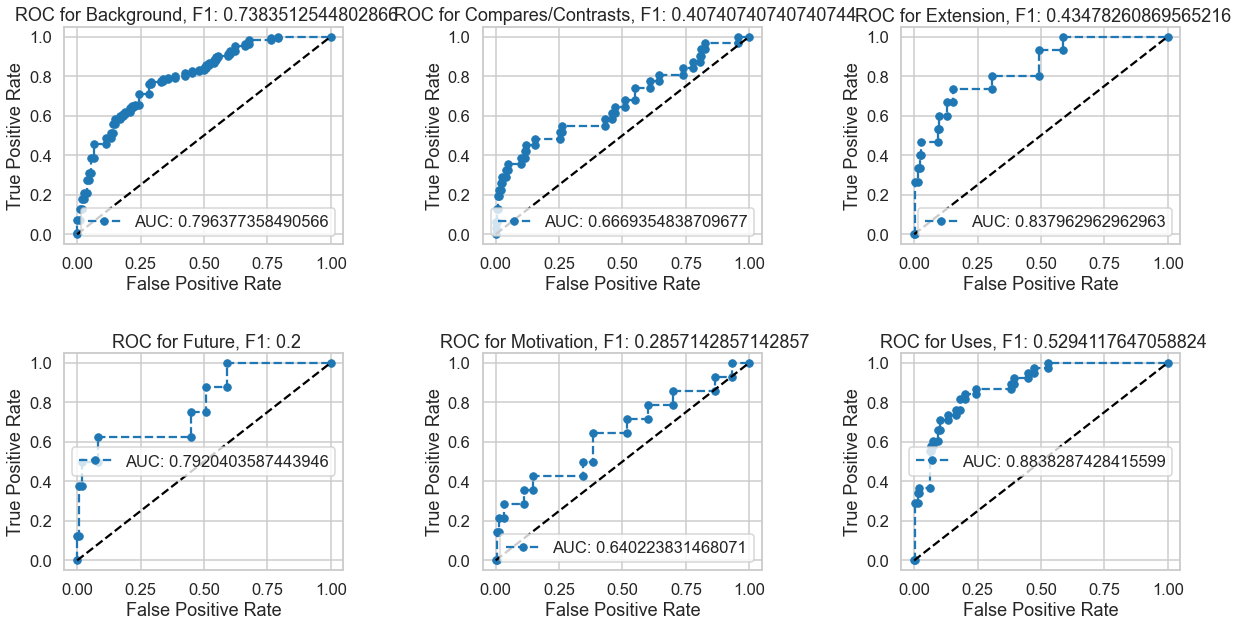

In [21]:
import sys
sys.path.insert(1, "../../Utilties")
from metrics import *

multiclass_metrics(y_true, y_pred)

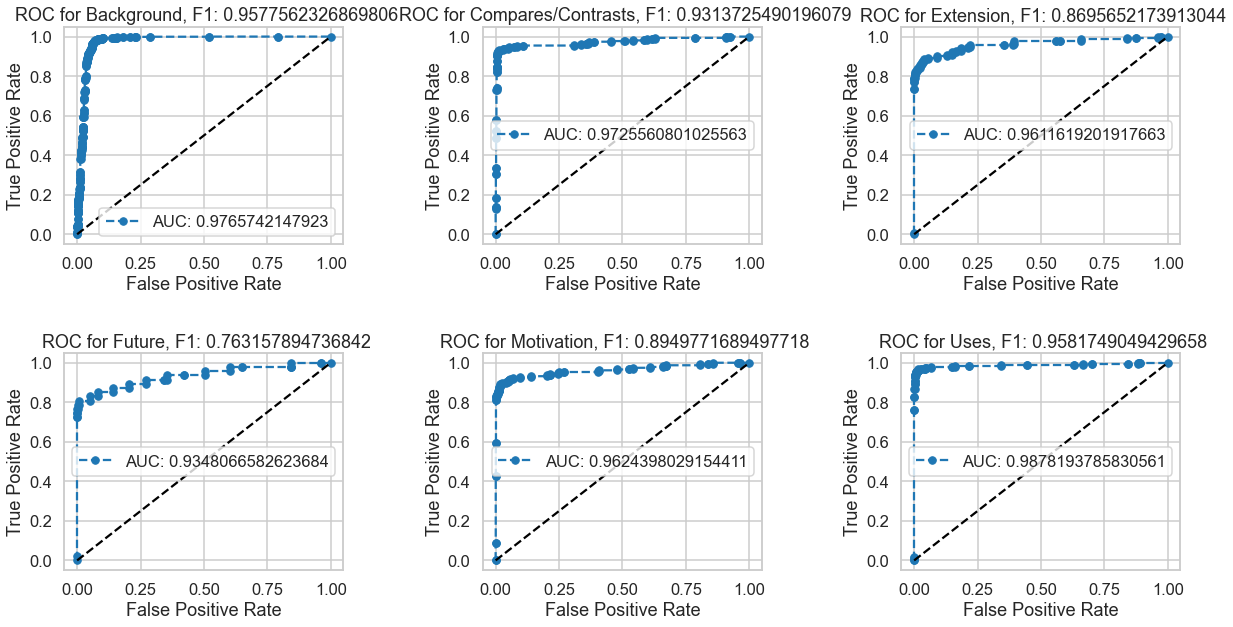

In [22]:
with torch.no_grad():
    y_true = []
    y_pred = []
    for batch_num, input_data in enumerate(train_loader):
        x,y = input_data
        x = x.to(device).float()
#         y = y.to(device).long()
        output = model(x)
        y_pred.extend(output.cpu().detach().numpy())
        y_true.extend(y.cpu().detach().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)

multiclass_metrics(y_true, y_pred)

### Val 

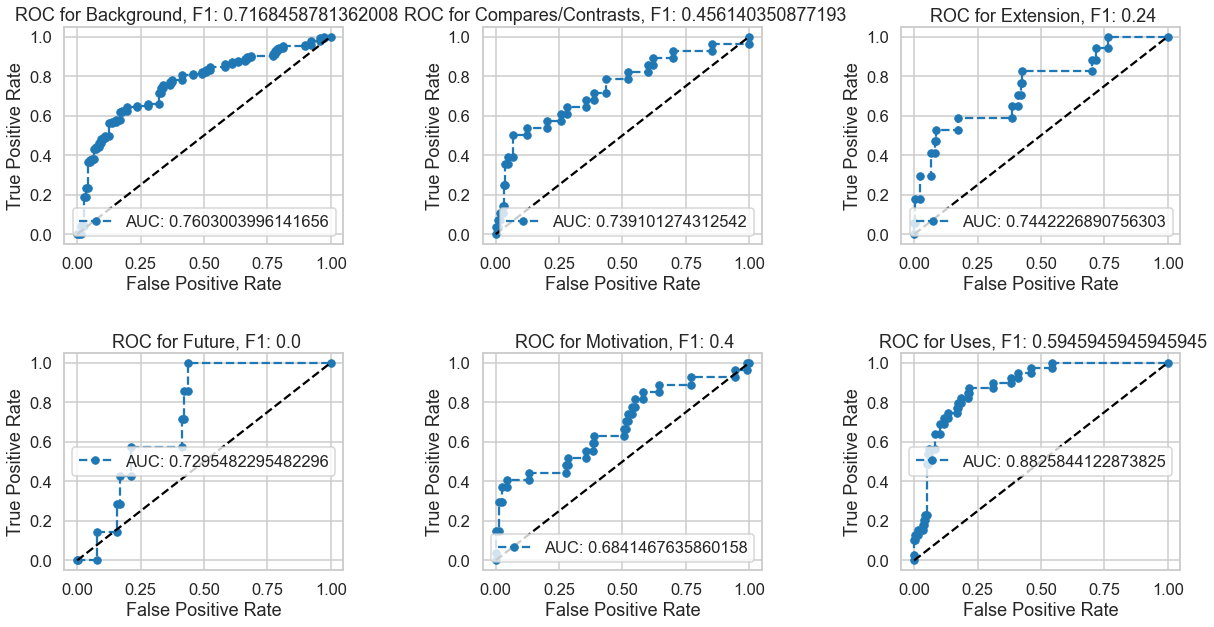

In [23]:
with torch.no_grad():
    y_true = []
    y_pred = []
    for batch_num, input_data in enumerate(val_loader):
        x,y = input_data
        x = x.to(device).float()
#         y = y.to(device).long()
        output = model(x)
        y_pred.extend(output.cpu().detach().numpy())
        y_true.extend(y.cpu().detach().numpy())
y_pred = np.array(y_pred)[:, 0, :]
y_true = np.array(y_true)

multiclass_metrics(y_true, y_pred)

### Competition Inference

Finally, because of the promising ROCs as seen above, I attempt to run the same basic model with train-fit TFIDF vectors on the test set. I exported it and submitted it for the multiclass task and got a score of 0.19. 

In [24]:
testdf = pd.read_csv("../../Data/SDP_test.csv")
print(testdf)

    unique_id    core_id                                       citing_title  \
0        CCT1   81153632  Two steps back, one step forward: reconstructi...   
1        CCT2   81153632  Two steps back, one step forward: reconstructi...   
2        CCT3   81153632  Two steps back, one step forward: reconstructi...   
3        CCT4   81153632  Two steps back, one step forward: reconstructi...   
4        CCT5   81153632  Two steps back, one step forward: reconstructi...   
..        ...        ...                                                ...   
995    CCT996  187054964  Clinical Study Peritoneal Dialysis as a First ...   
996    CCT997  189217163  The trajectory of neurotoxic side effects' imp...   
997    CCT998  189217163  The trajectory of neurotoxic side effects' imp...   
998    CCT999  189217163  The trajectory of neurotoxic side effects' imp...   
999   CCT1000  189217163  The trajectory of neurotoxic side effects' imp...   

           citing_author                           

In [25]:
for core_id in tqdm(testdf['core_id']):
    process_article(core_id)
    
test_frame = pd.DataFrame([find_position_in_article(testdf, idx) for idx in tqdm(range(len(testdf)))], columns=['section', 'sent_idx'])
test_frame["core_id"] = testdf['core_id']

test_frame["local_sentence"] = [get_local_sentences(testdf, idx, test_frame.iloc[idx].section, test_frame.iloc[idx].sent_idx) for idx in tqdm(range(len(testdf)))]

# total_corpus = np.concatenate((test_frame["local_sentence"].values, new_frame["local_sentence"].values), axis=0)
# print(total_corpus.shape)

# vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b', ngram_range=(1, 1))
# X = vectorizer.fit_transform(test_frame["local_sentence"])

X = vectorizer.transform(test_frame["local_sentence"])

testdf["tfidf"] = [X[i].toarray() for i in range(X.shape[0])]
print(X.shape[0])
                   
competition_test_set = TestDataset(testdf, labels=False)
competition_loader = DataLoader(competition_test_set, batch_size = batch_size, shuffle=False)

 88%|████████████████████████████████████████████████████████████████████▎         | 876/1000 [00:02<00:00, 403.76it/s]

Article 82105846 doesn't have abstract, please double check to make sure


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 714.27it/s]


1000


In [26]:
with torch.no_grad():
    y_pred = []
    for batch_num, input_data in enumerate(competition_loader):
        x = input_data
        x = x.to(device).float()
        print(x.shape)
#         y = y.to(device).long()
        output = model(x)
        y_pred.extend(output.cpu().detach().numpy())
y_pred = np.array(y_pred)[:,0,:]
y_pred = np.argmax(y_pred, axis=1)

torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([32, 1, 16071])
torch.Size([8, 1, 16071])


In [27]:
testdf['citation_class_label'] = y_pred
testdf[['unique_id', 'citation_class_label']].to_csv("../submission.csv", index=False)